<a href="https://colab.research.google.com/github/OliverMaerz/Covid-19/blob/master/Covid19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 - New Cases, Deaths, Recovered - Death Rate - Reproduction Number (R)

Generated with data from Johns Hopkins CSSE: https://github.com/CSSEGISandData




Set the list of countries we want to take a look at:

In [0]:
# selected_countries = ['Argentina', 'Spain', 'Italy', 'Brazil', 'Chile', 
#                       'Germany', 'US', 'France', 'United Kingdom']

selected_countries = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Peru']

First: Download the Johns Hopkins CSSE global dataset for Covid-19:

In [2]:
!curl -o confirmed.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!curl -o deaths.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!curl -o recovered.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  137k  100  137k    0     0   967k      0 --:--:-- --:--:-- --:--:--  974k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100k  100  100k    0     0  1378k      0 --:--:-- --:--:-- --:--:-- 1378k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  117k  100  117k    0     0  1591k      0 --:--:-- --:--:-- --:--:-- 1591k


Next: Import the libraries we will use for data wrangling and display:

In [0]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [40, 20]
import numpy as np
import pandas as pd

Load the downloaded dataset (csv files) into [Pandas](https://pandas.pydata.org/) dataframes and remove columns we do not need:

In [0]:
confirmed_df = pd.read_csv('confirmed.csv', sep=',', header=0, 
                           error_bad_lines=False)
deaths_df = pd.read_csv('deaths.csv', sep=',', header=0, 
                        error_bad_lines=False)
recovered_df = pd.read_csv('recovered.csv', sep=',', header=0, 
                           error_bad_lines=False)

Define helper functions

In [0]:
# Get a new dataframe with only the countries that are in the 
# selected_countries list and drop the rest
def get_selected_countries(df):
    selected_df = df.loc[df['Country/Region'].isin(selected_countries) & \
                         df['Province/State'].isnull()].copy()
    selected_df.set_index('Country/Region', inplace=True)
    # drop some columns we will no longer need
    selected_df.drop(['Lat', 'Long', 'Province/State'], axis=1, inplace=True)
    # convert the column names to date-time format
    selected_df.columns = pd.to_datetime(selected_df.columns)
    return selected_df


# Get the new cases, deaths, or recovered cases by calculating the difference
# to the previous days for each day
def get_difference_between_days(df):
    diff_df = df.diff(axis=1)
    # drop the first column as there is no previous day to calculate the 
    # difference 
    diff_df.drop(diff_df.columns[0], axis='columns', inplace=True)
    # drop any zero colums
    diff_df = diff_df.loc[:, (diff_df != 0).any(axis=0)]
    # get rid of negative values
    diff_df[diff_df < 0] = 0
    return diff_df
     

## Create dataframe with selected countries and new confirmed cases per day

In [6]:
selected_confirmed_df = get_selected_countries(confirmed_df)
new_confirmed_df = get_difference_between_days(selected_confirmed_df)
new_confirmed_df

,2020-02-26,2020-02-29,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,...,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,1.0,0.0,0.0,1.0,6.0,4.0,0.0,5.0,2.0,0.0,12.0,3.0,11.0,11.0,12.0,11.0,18.0,31.0,30.0,108.0,35.0,86.0,0.0,115.0,87.0,101.0,55.0,75.0,234.0,0.0,79.0,132.0,186.0,0.0,103.0,74.0,87.0,80.0,...,188.0,163.0,240.0,165.0,258.0,244.0,285.0,316.0,255.0,345.0,326.0,263.0,303.0,438.0,474.0,648.0,718.0,704.0,723.0,552.0,600.0,705.0,769.0,717.0,795.0,637.0,564.0,904.0,949.0,929.0,840.0,983.0,774.0,826.0,1141.0,1226.0,1386.0,1391.0,1531.0,1282.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,7.0,0.0,1.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,2.0,3.0,11.0,18.0,13.0,7.0,16.0,10.0,8.0,8.0,9.0,7.0,18.0,26.0,11.0,16.0,54.0,...,84.0,195.0,185.0,171.0,119.0,275.0,133.0,184.0,224.0,205.0,249.0,262.0,175.0,218.0,438.0,268.0,392.0,336.0,348.0,397.0,476.0,632.0,619.0,344.0,861.0,390.0,549.0,460.0,647.0,607.0,483.0,630.0,285.0,306.0,695.0,637.0,884.0,764.0,913.0,617.0
Brazil,1.0,1.0,0.0,2.0,0.0,9.0,0.0,7.0,5.0,6.0,7.0,14.0,99.0,0.0,11.0,38.0,121.0,51.0,249.0,172.0,228.0,525.0,378.0,323.0,307.0,431.0,432.0,487.0,352.0,323.0,1138.0,1119.0,1208.0,1012.0,1304.0,770.0,1031.0,1873.0,2136.0,1922.0,...,11156.0,9162.0,11121.0,9167.0,6638.0,6895.0,8620.0,11923.0,13028.0,17126.0,13220.0,7569.0,14288.0,16517.0,19694.0,18508.0,20803.0,16508.0,15813.0,11687.0,16324.0,20599.0,26417.0,26928.0,33274.0,16409.0,11598.0,28936.0,28633.0,30925.0,30830.0,27075.0,18912.0,15654.0,32091.0,32913.0,30412.0,25982.0,21704.0,17110.0
Chile,0.0,0.0,1.0,0.0,3.0,0.0,0.0,4.0,0.0,5.0,10.0,0.0,20.0,18.0,13.0,81.0,46.0,37.0,0.0,196.0,103.0,95.0,114.0,176.0,220.0,164.0,304.0,299.0,230.0,310.0,289.0,293.0,373.0,333.0,424.0,310.0,344.0,301.0,430.0,426.0,...,1032.0,1533.0,1391.0,1247.0,1647.0,1197.0,1658.0,2660.0,2659.0,2502.0,1886.0,2353.0,2278.0,3520.0,4038.0,3964.0,4276.0,3536.0,3709.0,4895.0,3964.0,4328.0,4654.0,3695.0,4220.0,4830.0,5470.0,3528.0,4942.0,4664.0,4207.0,5246.0,6405.0,4696.0,3913.0,5697.0,5636.0,6754.0,6509.0,6938.0
Peru,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,0.0,4.0,13.0,10.0,5.0,43.0,31.0,28.0,89.0,0.0,84.0,45.0,32.0,21.0,64.0,100.0,55.0,36.0,181.0,98.0,115.0,258.0,91.0,181.0,151.0,535.0,280.0,393.0,1388.0,914.0,...,3628.0,3709.0,3321.0,3168.0,2292.0,1515.0,3237.0,4247.0,4298.0,3891.0,4046.0,3732.0,2660.0,4550.0,4537.0,4749.0,2929.0,4056.0,4205.0,4020.0,5772.0,6154.0,5874.0,6506.0,7386.0,8805.0,5563.0,0.0,8875.0,4284.0,4202.0,4358.0,4757.0,3181.0,4040.0,5087.0,5965.0,0.0,5961.0,8987.0


## Plot new confirmed cases per day

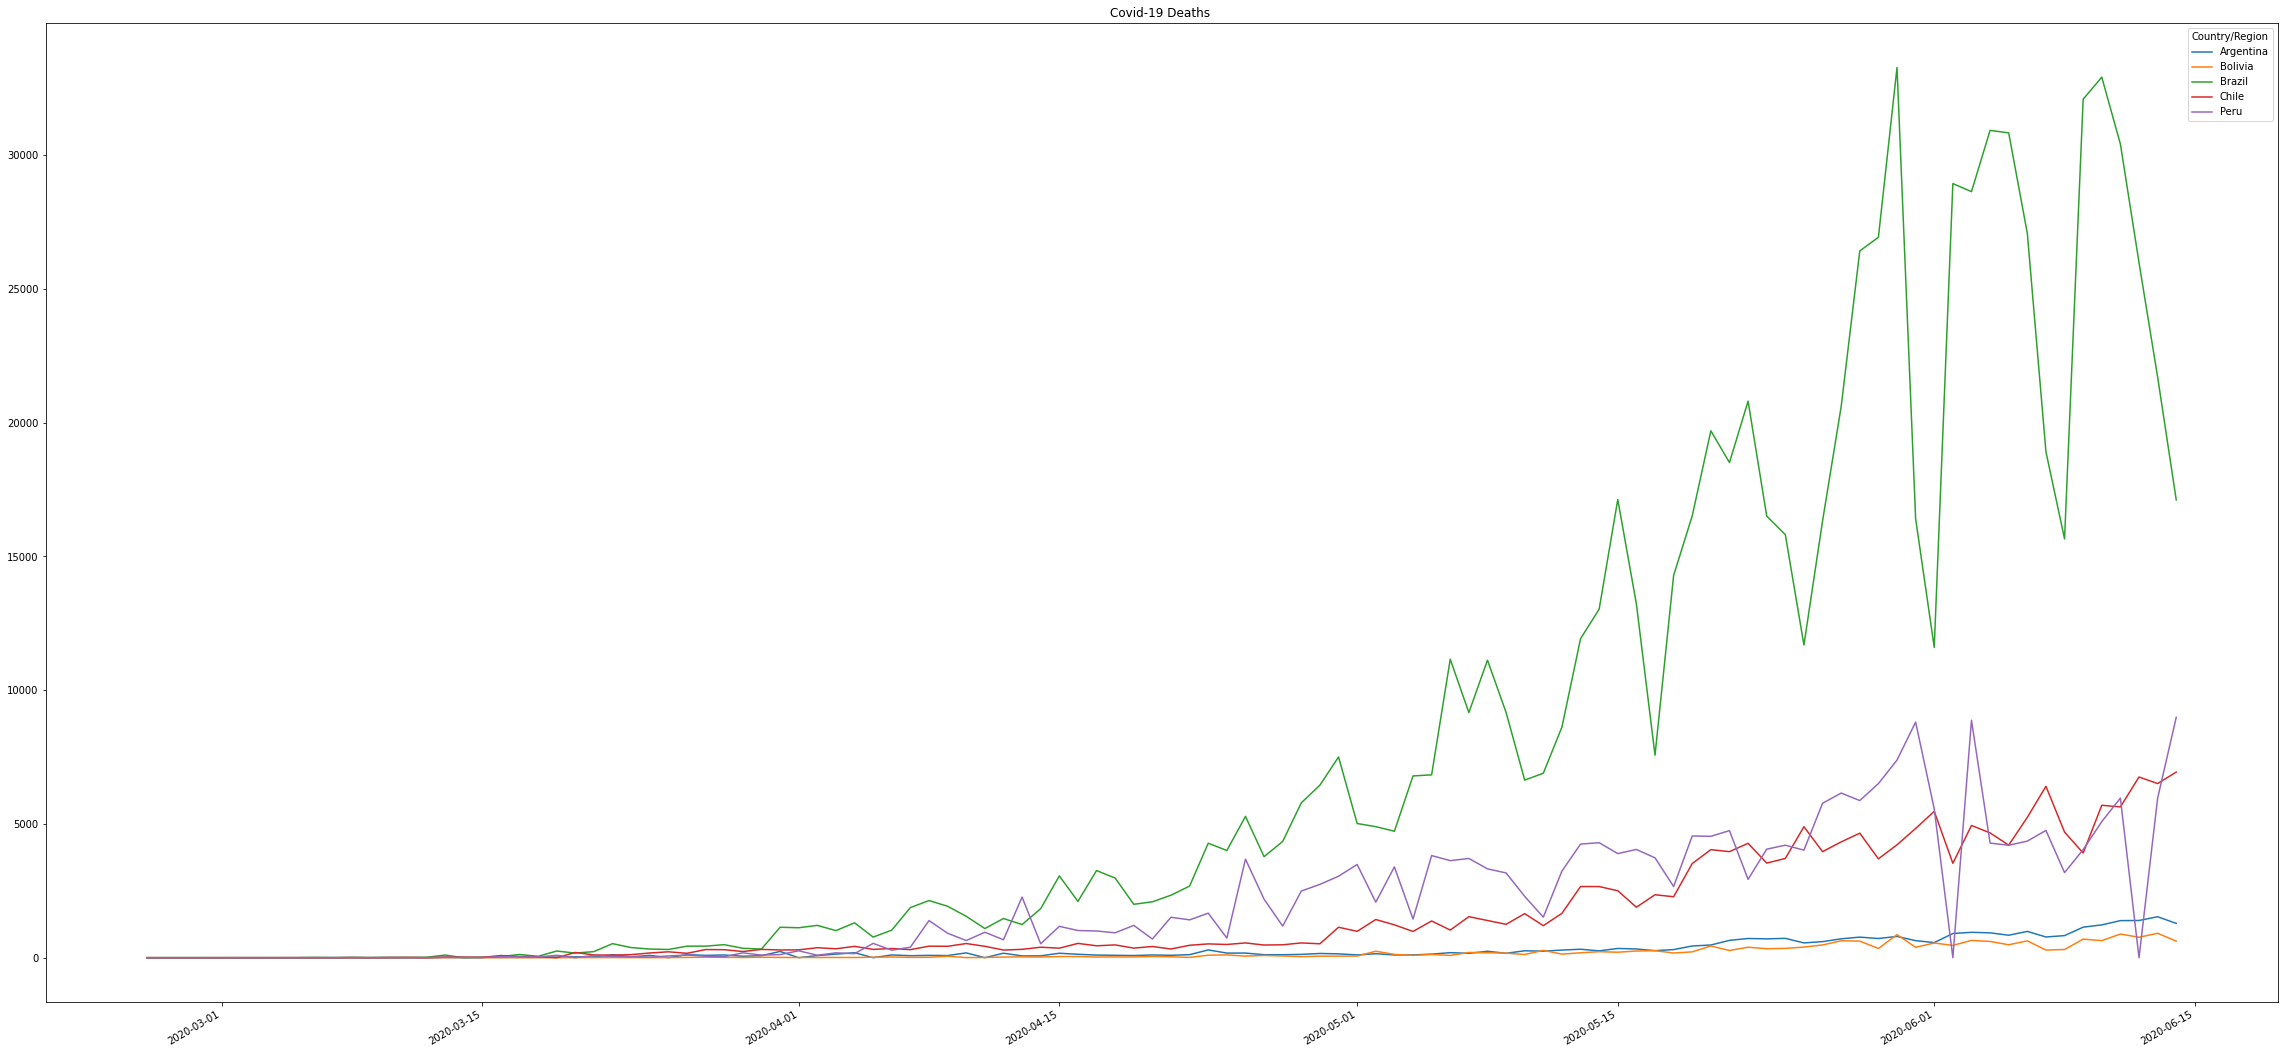

In [7]:
new_confirmed_df.transpose().plot(kind='line', title='Covid-19 Deaths ', 
                                  logy=False)

## Create dataframe with selected countries and number of deaths per day

In [8]:
selected_deaths_df = get_selected_countries(deaths_df)
new_deaths_df = get_difference_between_days(selected_deaths_df)
new_deaths_df

,2020-03-08,2020-03-13,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,...,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,4.0,5.0,1.0,4.0,4.0,1.0,8.0,3.0,4.0,1.0,4.0,8.0,7.0,9.0,10.0,1.0,7.0,7.0,5.0,9.0,4.0,8.0,6.0,3.0,4.0,11.0,5.0,13.0,...,9.0,9.0,11.0,7.0,5.0,9.0,5.0,10.0,24.0,3.0,7.0,10.0,9.0,11.0,10.0,13.0,17.0,12.0,7.0,15.0,17.0,16.0,8.0,12.0,8.0,11.0,17.0,13.0,14.0,25.0,24.0,16.0,16.0,29.0,24.0,18.0,30.0,20.0,30.0,18.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,3.0,1.0,1.0,4.0,3.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,3.0,6.0,...,5.0,11.0,4.0,8.0,4.0,4.0,6.0,14.0,10.0,12.0,1.0,4.0,5.0,15.0,10.0,16.0,15.0,10.0,10.0,11.0,13.0,6.0,13.0,7.0,10.0,3.0,30.0,33.0,24.0,15.0,12.0,27.0,11.0,10.0,12.0,25.0,21.0,26.0,26.0,26.0
Brazil,0.0,0.0,1.0,2.0,3.0,5.0,4.0,10.0,9.0,12.0,13.0,18.0,15.0,19.0,25.0,23.0,42.0,39.0,84.0,35.0,86.0,41.0,78.0,122.0,133.0,131.0,107.0,67.0,99.0,105.0,204.0,204.0,188.0,217.0,213.0,108.0,125.0,154.0,165.0,425.0,...,650.0,602.0,827.0,639.0,467.0,530.0,808.0,779.0,759.0,963.0,700.0,456.0,735.0,1130.0,876.0,1188.0,1001.0,965.0,653.0,807.0,1039.0,1086.0,1156.0,1124.0,956.0,480.0,623.0,1262.0,1349.0,1473.0,1005.0,904.0,525.0,679.0,1272.0,1274.0,1239.0,909.0,892.0,612.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,2.0,4.0,5.0,7.0,3.0,6.0,5.0,9.0,8.0,8.0,7.0,2.0,10.0,2.0,11.0,11.0,10.0,7.0,6.0,8.0,13.0,8.0,...,6.0,4.0,9.0,10.0,8.0,11.0,12.0,11.0,22.0,26.0,27.0,29.0,28.0,31.0,35.0,45.0,41.0,43.0,45.0,43.0,45.0,35.0,49.0,54.0,53.0,57.0,59.0,75.0,87.0,81.0,92.0,93.0,96.0,627.0,19.0,192.0,173.0,222.0,231.0,222.0
Peru,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,5.0,2.0,6.0,6.0,8.0,17.0,6.0,12.0,10.0,9.0,15.0,14.0,17.0,31.0,12.0,12.0,23.0,14.0,24.0,20.0,26.0,48.0,52.0,45.0,39.0,46.0,42.0,...,89.0,94.0,87.0,100.0,75.0,72.0,96.0,112.0,98.0,125.0,131.0,125.0,141.0,125.0,110.0,124.0,96.0,129.0,83.0,173.0,159.0,195.0,116.0,131.0,141.0,135.0,128.0,0.0,260.0,137.0,131.0,139.0,164.0,106.0,167.0,165.0,185.0,0.0,220.0,380.0


## Plot number of deaths per day

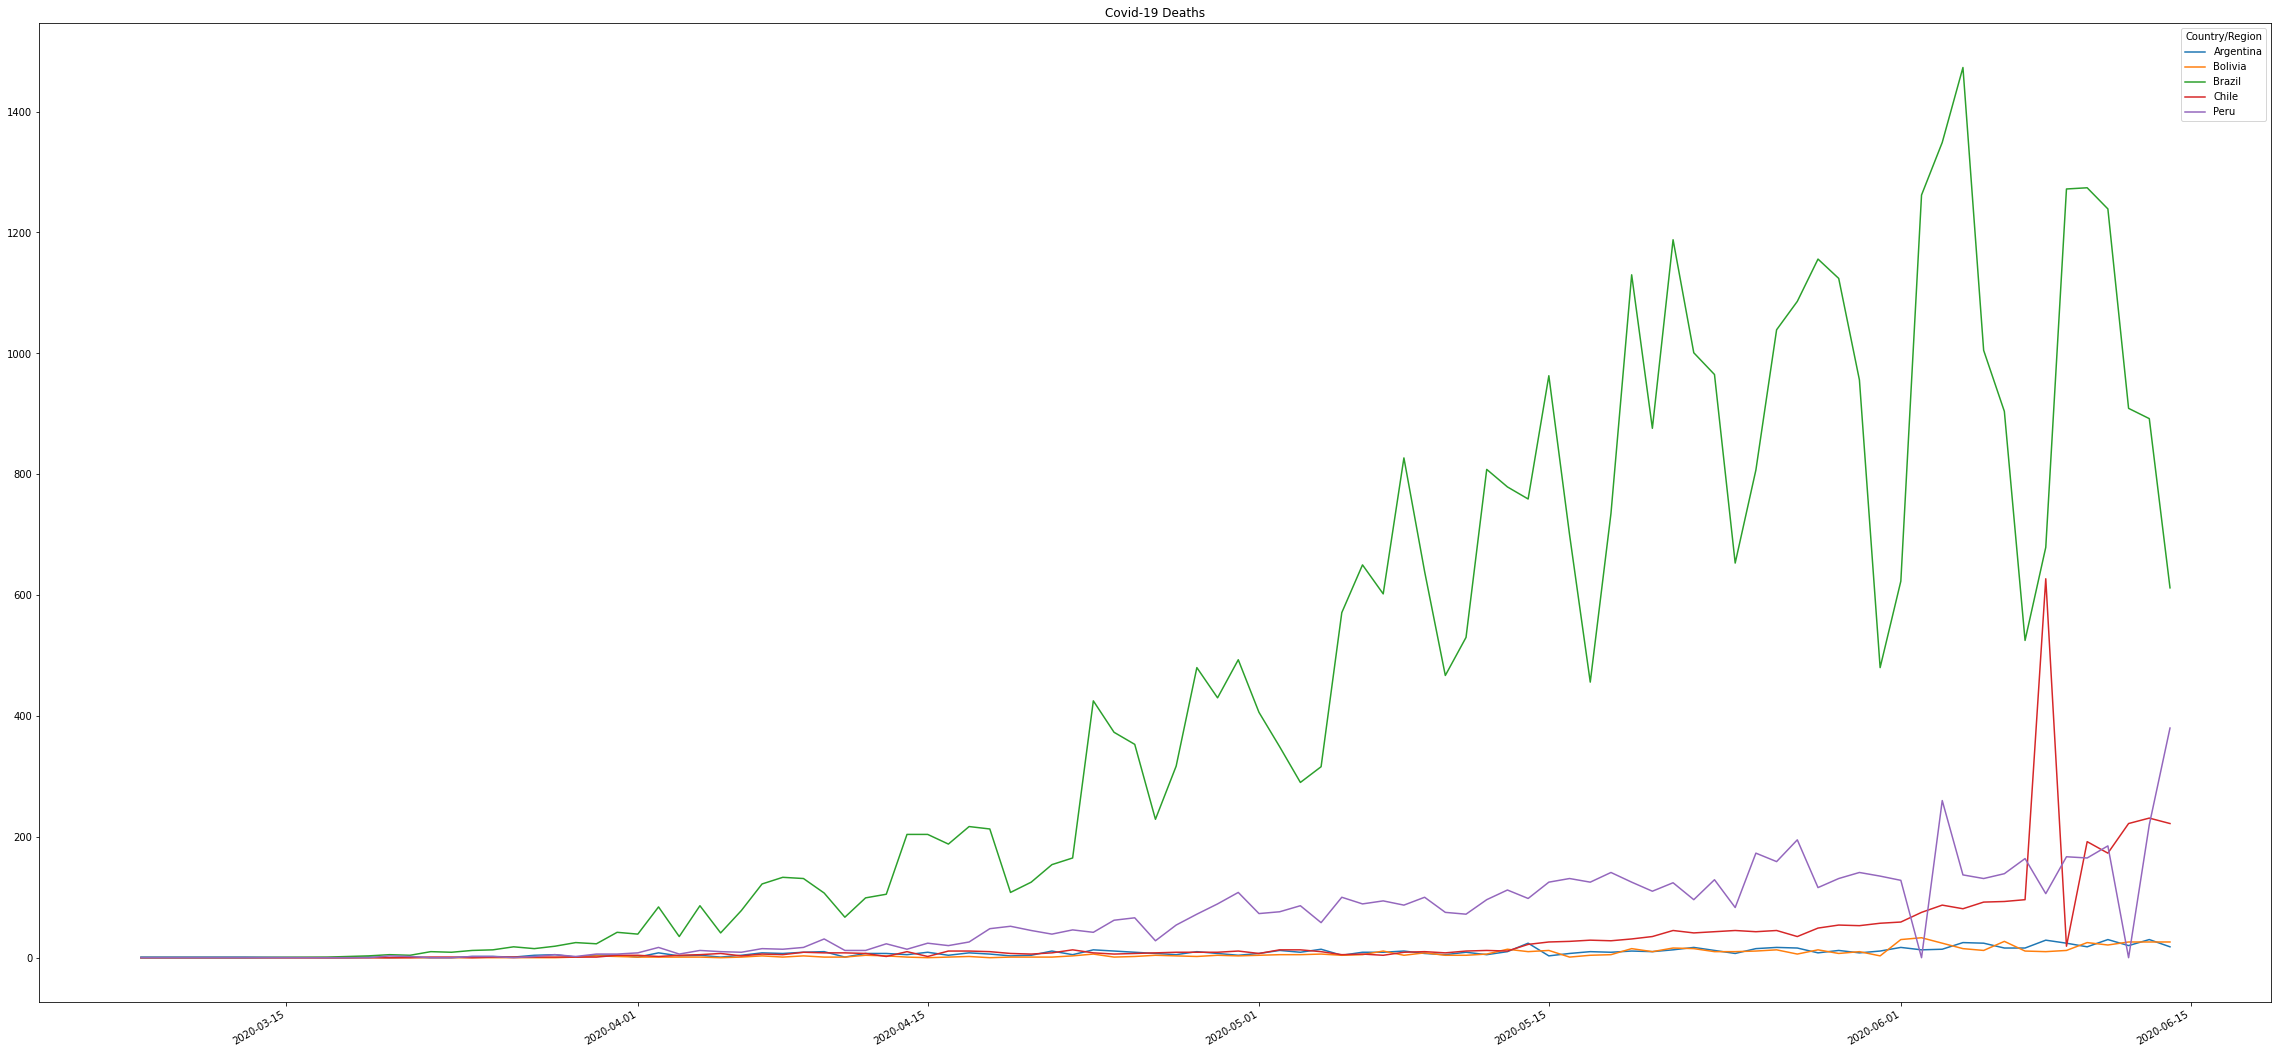

In [9]:
new_deaths_df.transpose().plot(kind='line', title='Covid-19 Deaths', logy=False)

## Create dataframe with selected countries and number of recovered patients per day

In [10]:
selected_recovered_df = get_selected_countries(recovered_df)
new_recovered_df = get_difference_between_days(selected_recovered_df)
new_recovered_df

,2020-03-14,2020-03-16,2020-03-17,2020-03-20,2020-03-22,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,...,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,1.0,0.0,2.0,0.0,0.0,49.0,0.0,11.0,9.0,0.0,0.0,156.0,12.0,8.0,8.0,10.0,13.0,1.0,45.0,13.0,20.0,7.0,10.0,65.0,28.0,47.0,44.0,37.0,35.0,35.0,19.0,24.0,28.0,103.0,32.0,47.0,57.0,54.0,77.0,33.0,...,52.0,77.0,58.0,69.0,29.0,80.0,25.0,404.0,119.0,112.0,37.0,35.0,56.0,247.0,61.0,99.0,30.0,468.0,202.0,267.0,168.0,182.0,268.0,171.0,0.0,548.0,185.0,188.0,187.0,97.0,95.0,92.0,729.0,396.0,263.0,423.0,341.0,411.0,340.0,481.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,7.0,12.0,5.0,0.0,0.0,6.0,7.0,0.0,10.0,0.0,26.0,18.0,...,11.0,21.0,18.0,21.0,15.0,26.0,14.0,26.0,17.0,78.0,39.0,20.0,10.0,30.0,20.0,8.0,14.0,34.0,20.0,18.0,30.0,12.0,49.0,11.0,140.0,79.0,169.0,161.0,209.0,151.0,81.0,163.0,184.0,73.0,31.0,71.0,111.0,59.0,337.0,345.0
Brazil,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,114.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,2873.0,10980.0,0.0,0.0,0.0,8104.0,0.0,861.0,2327.0,1255.0,1082.0,1505.0,992.0,990.0,...,3149.0,3980.0,3947.0,2388.0,3272.0,2427.0,5213.0,5827.0,1055.0,5491.0,4702.0,4450.0,6337.0,6335.0,9889.0,9277.0,9470.0,7157.0,7324.0,3922.0,4760.0,8054.0,10957.0,11872.0,11416.0,5663.0,4525.0,12558.0,14979.0,16346.0,11977.0,10209.0,6803.0,94305.0,18480.0,17179.0,16049.0,15158.0,14313.0,9705.0
Chile,0.0,0.0,0.0,6.0,2.0,9.0,5.0,0.0,21.0,18.0,14.0,81.0,0.0,78.0,101.0,92.0,101.0,90.0,110.0,170.0,217.0,159.0,297.0,293.0,195.0,308.0,279.0,291.0,362.0,322.0,414.0,303.0,338.0,293.0,417.0,418.0,523.0,419.0,278.0,303.0,...,479.0,475.0,496.0,507.0,445.0,493.0,520.0,740.0,790.0,959.0,1400.0,1199.0,952.0,1342.0,997.0,1488.0,1350.0,1204.0,1602.0,1154.0,1613.0,2625.0,2575.0,2483.0,1833.0,2296.0,2219.0,41227.0,4575.0,4883.0,3727.0,4459.0,4333.0,4098.0,5113.0,4419.0,4664.0,4914.0,5938.0,6408.0
Peru,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0,0.0,0.0,37.0,341.0,0.0,143.0,0.0,377.0,75.0,8.0,304.0,32.0,105.0,131.0,170.0,59.0,844.0,227.0,239.0,3012.0,421.0,143.0,127.0,157.0,14.0,45.0,395.0,74.0,301.0,291.0,337.0,...,2114.0,861.0,624.0,1234.0,1103.0,1057.0,918.0,1000.0,827.0,1996.0,1125.0,349.0,1685.0,6218.0,5444.0,1619.0,1261.0,3067.0,1880.0,1154.0,1957.0,3263.0,3273.0,3349.0,3656.0,761.0,1299.0,750.0,3062.0,3909.0,2986.0,3517.0,3488.0,3337.0,3373.0,5102.0,4398.0,4704.0,4591.0,3855.0


## Plot number of recovered patients per day

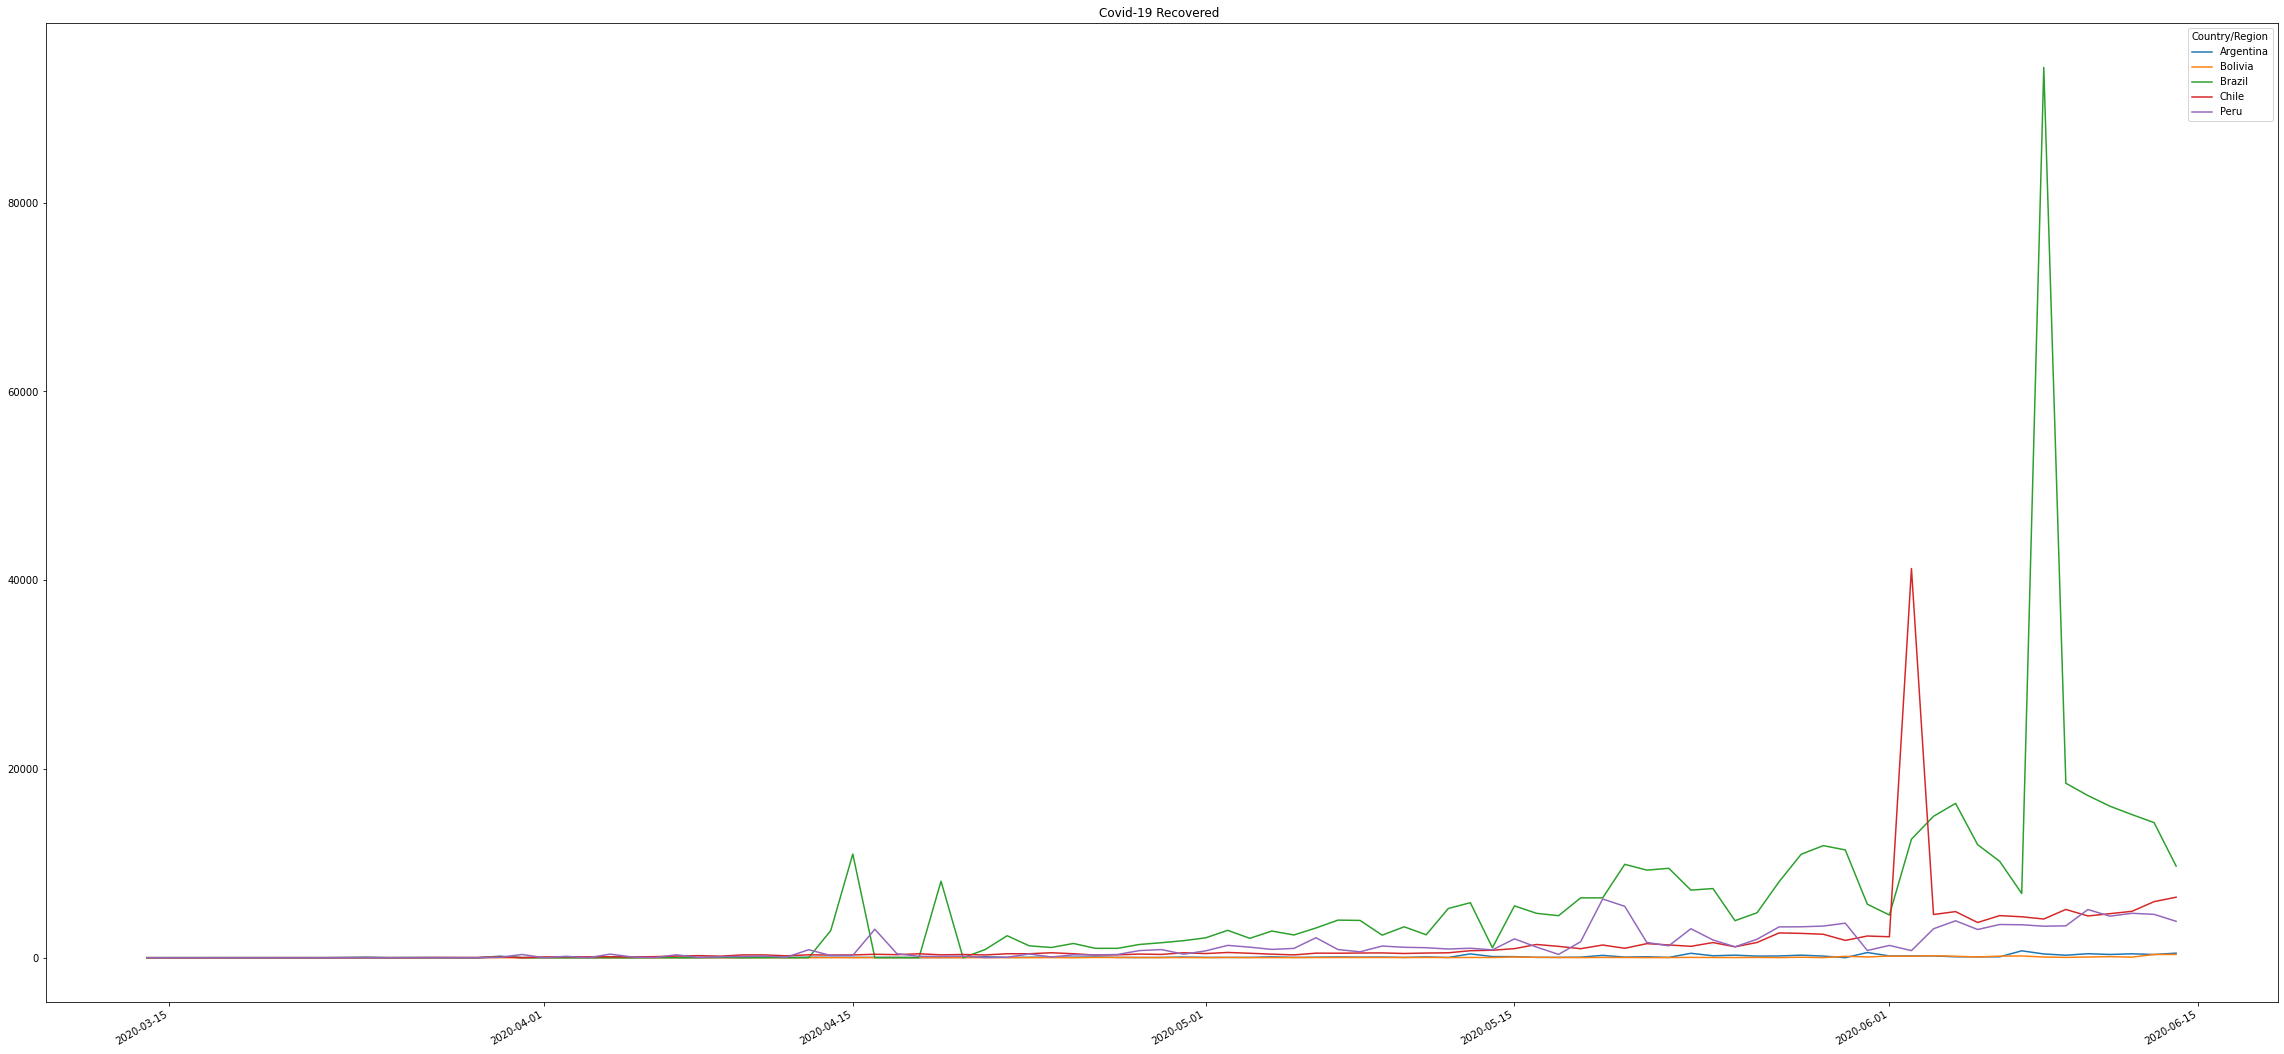

In [11]:
new_recovered_df.transpose().plot(kind='line', title='Covid-19 Recovered ', 
                                  logy=False)

## Calculate death rate based on all cases (recovered, deaths, still with Covid-19)

In [12]:
death_rate_vs_confirmed = selected_deaths_df.iloc[:,-1] \
                          / selected_confirmed_df.iloc[:,-1] 
death_rate_vs_confirmed

Country/Region
Argentina    0.026380
Bolivia      0.033100
Brazil       0.049943
Chile        0.019066
Peru         0.029112
Name: 2020-06-14 00:00:00, dtype: float64

## Calculate death rate based on number of recovered patients plus deaths

In [13]:
death_rate_vs_recovered = selected_deaths_df.iloc[:,-1] / \
                          (selected_recovered_df.iloc[:,-1] + \
                           selected_deaths_df.iloc[:,-1])
death_rate_vs_recovered

Country/Region
Argentina    0.080119
Bolivia      0.164071
Brazil       0.084555
Chile        0.022601
Peru         0.054700
Name: 2020-06-14 00:00:00, dtype: float64

## Calculate reproduction number 
Last four days vs. previous four days 

```Reff(t) = (N(t)+N(t-1)+N(t-2)+N(t-3)) / (N(t-4)+N(t-5)+N(t-6)+N(t-7))``` 

In [14]:
# divide new cases from last four days with new cases from previous four days
reproduction_df = (new_confirmed_df.iloc[:,-1] \
                   + new_confirmed_df.iloc[:,-2] \
                   + new_confirmed_df.iloc[:,-3] \
                   + new_confirmed_df.iloc[:,-4]) \
                  / (new_confirmed_df.iloc[:,-5] \
                   + new_confirmed_df.iloc[:,-6] \
                   + new_confirmed_df.iloc[:,-7] \
                   + new_confirmed_df.iloc[:,-8])
reproduction_df

Country/Region
Argentina    1.409125
Bolivia      1.652626
Brazil       0.956192
Chile        1.247501
Peru         1.225491
dtype: float64